In [22]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
train_file = "./train.csv"
test_file = "./test.csv"
num_cols = ["ps_reg_01", "ps_reg_02", "ps_reg_03","ps_car_12", "ps_car_13", "ps_car_14", "ps_car_15"]
ignore_cols = ["id", "target", "ps_calc_01", "ps_calc_02", "ps_calc_03", "ps_calc_04", "ps_calc_05", 
               "ps_calc_06", "ps_calc_07", "ps_calc_08", "ps_calc_09", "ps_calc_10", "ps_calc_11", 
               "ps_calc_12", "ps_calc_13", "ps_calc_14","ps_calc_15_bin", "ps_calc_16_bin", 
               "ps_calc_17_bin","ps_calc_18_bin", "ps_calc_19_bin", "ps_calc_20_bin"]

In [3]:
cfg = {
    "feature_size": None,
    "field_size": None,
    "embed_size":128,
    "deep_nn":[256,256],
    "dropout_fm": 0,
    "dropout_deep": 0.2,
    "output_bias": None,
    "epoch":200,
    "batch":10000,
    "split": 0.2
}

In [4]:
def overview(cfg):    
    dfTrain = pd.read_csv(train_file)
    dfTest = pd.read_csv(test_file)
    df = pd.concat([dfTrain,dfTest], sort=False)

    field_size = len(df.columns) - len(ignore_cols)
    feature_dict = {}
    feature_size = 0
    for col in df.columns:
        if col in ignore_cols:
            continue
        elif col in num_cols:
            feature_dict[col] = feature_size
            feature_size += 1
        else:
            unique_val = df[col].unique()
            feature_dict[col] = dict(zip(unique_val,range(feature_size,len(unique_val) + feature_size)))
            feature_size += len(unique_val)
    
    cfg['field_size'] = field_size
    cfg['feature_size'] = feature_size
    return dfTrain, feature_dict

In [5]:
dfTrain, feature_dict = overview(cfg)

In [6]:
def preprocess(train_df, feature_dict, cfg):
    label_df = train_df[['target']]    
    train_df.drop(['target','id'],axis=1,inplace=True)
    feature_idx = train_df.copy()
    feature_val = train_df.copy()
    for col in feature_idx.columns:
        if col in ignore_cols:
            feature_idx.drop(col,axis=1,inplace=True)
            feature_val.drop(col,axis=1,inplace=True)
            continue
        elif col in num_cols:
            feature_idx[col] = feature_dict[col]
        else:
            feature_idx[col] = feature_idx[col].map(feature_dict[col])
            feature_val[col] = 1      
            
    train_idx_df, test_idx_df = train_test_split(feature_idx, test_size=cfg["split"])
    train_val_df, test_val_df = train_test_split(feature_val, test_size=cfg["split"])
    train_label_df, test_label_df = train_test_split(label_df, test_size=cfg["split"])
    
    train_idx_df, validate_idx_df = train_test_split(train_idx_df, test_size=cfg["split"])
    train_val_df, validate_val_df = train_test_split(train_val_df, test_size=cfg["split"])
    train_label_df, validate_label_df = train_test_split(train_label_df, test_size=cfg["split"])
    
    train_input = [train_idx_df.values, train_val_df.values]
    train_label = np.array(train_label_df['target'])
    bool_train_labels = train_label != 0
    
    validate_input = [validate_idx_df.values, validate_val_df.values]
    validate_label = validate_label_df.values
    
    test_input = [test_idx_df.values, test_val_df.values]
    test_label = test_label_df.values
    
    return train_input, train_label, bool_train_labels, validate_input, validate_label, test_input, test_label

In [7]:
train_input, train_label, bool_train_labels, validate_input, validate_label, test_input, test_label = preprocess(dfTrain, feature_dict, cfg)

In [8]:
def oversample(train_input, train_label, bool_train_labels):
    pos_idx = train_input[0][bool_train_labels]
    neg_idx = train_input[0][~bool_train_labels]
    pos_val = train_input[1][bool_train_labels]
    neg_val = train_input[1][~bool_train_labels]
    pos_label = train_label[bool_train_labels]
    neg_label = train_label[~bool_train_labels]
    
    ids = np.arange(len(pos_idx))
    choices = np.random.choice(ids, len(neg_idx))
    
    res_pos_idx = pos_idx[choices]
    res_pos_val = pos_val[choices]
    res_pos_label = pos_label[choices]
    
    resampled_idx = np.concatenate([res_pos_idx, neg_idx], axis=0)
    resampled_val = np.concatenate([res_pos_val, neg_val], axis=0)
    resampled_label = np.concatenate([res_pos_label, neg_label], axis=0)

    order = np.arange(len(resampled_label))
    np.random.shuffle(order)    
    return [resampled_idx[order], resampled_val[order]], resampled_label[order]

In [9]:
res_train_input, res_train_label = oversample(train_input, train_label, bool_train_labels)

In [10]:
class DeepFM(tf.keras.Model):
    def __init__(self, cfg):
        super(DeepFM, self).__init__()
        self.feature_size = cfg['feature_size']
        self.field_size = cfg['field_size']
        self.embed_size = cfg['embed_size']
        self.deep_nn = cfg['deep_nn']
        
        self.dropout_fm = cfg['dropout_fm']
        self.dropout_deep = cfg['dropout_deep']
        
        # fm        
        self.feature_weight = tf.keras.layers.Embedding(cfg['feature_size'], 1)
        self.feature_embed = tf.keras.layers.Embedding(cfg['feature_size'], cfg['embed_size'])

        # dnn
        for layer in range(len(cfg['deep_nn'])):
            setattr(self, 'dense_' + str(layer), tf.keras.layers.Dense(self.deep_nn[layer]))
            setattr(self, 'batchNorm_' + str(layer), tf.keras.layers.BatchNormalization())
            setattr(self, 'activation_' + str(layer), tf.keras.layers.Activation('relu'))
            setattr(self, 'dropout_' + str(layer), tf.keras.layers.Dropout(self.dropout_deep))
            
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid', 
                                        bias_initializer=tf.keras.initializers.Constant(cfg['output_bias']))

    def call(self, inputs, training=True):
        # inputs = [feature_idx, feature_val]
        reshaped_feature_val = tf.cast(tf.reshape(inputs[1], shape=[-1,self.field_size,1]), tf.float32)
        # linear        
        weights = self.feature_weight(inputs[0])
        linear = tf.reduce_sum(tf.multiply(weights,reshaped_feature_val),2)
        
        # fm  
        embeddings = self.feature_embed(inputs[0])
        second_inner = tf.multiply(embeddings,reshaped_feature_val)
        
        summed_features_emb = tf.reduce_sum(second_inner,1)
        summed_features_emb_square = tf.square(summed_features_emb)
        
        squared_features_emb = tf.square(second_inner)
        squared_sum_features_emb = tf.reduce_sum(squared_features_emb,1)
        
        fm = 0.5 * tf.subtract(summed_features_emb_square,squared_sum_features_emb)
        
        # dnn
        y_deep = tf.reshape(embeddings,shape=[-1,self.field_size * self.embed_size])
        for layer in range(0, len(self.deep_nn)):
            y_deep = getattr(self, 'dense_' + str(layer))(y_deep)
            y_deep = getattr(self, 'batchNorm_' + str(layer))(y_deep, training=training)
            y_deep = getattr(self, 'activation_' + str(layer))(y_deep)
            y_deep = getattr(self, 'dropout_' + str(layer))(y_deep, training=training)
            
        # concat
        concat = tf.concat([linear, fm, y_deep], axis=1)                                
        out = self.fc(concat)
        return out

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', verbose=1, patience=10, mode='max',restore_best_weights=True)
metrics = [tf.keras.metrics.TruePositives(name='tp'),
           tf.keras.metrics.FalsePositives(name='fp'),
           tf.keras.metrics.TrueNegatives(name='tn'),
           tf.keras.metrics.FalseNegatives(name='fn'), 
           tf.keras.metrics.BinaryAccuracy(name='bin_acc'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name='auc')]

In [12]:
model = DeepFM(cfg)
# model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['binary_accuracy'])
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=metrics)
hist = model.fit(res_train_input, res_train_label, epochs=cfg['epoch'], batch_size=cfg['batch'], shuffle=True, 
          verbose=1, callbacks = [early_stopping], validation_data=(validate_input, validate_label))

Train on 734120 samples, validate on 95234 samples
Epoch 1/200
734120/734120 [==============================] - 11s 15us/sample - loss: 0.6934 - tp: 26292.0000 - fp: 19419.0000 - tn: 347641.0000 - fn: 340768.0000 - bin_acc: 0.5094 - precision: 0.5752 - recall: 0.0716 - auc: 0.5464 - val_loss: 0.7891 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 91772.0000 - val_fn: 3462.0000 - val_bin_acc: 0.9636 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5031
Epoch 2/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.6798 - tp: 57452.0000 - fp: 20415.0000 - tn: 346645.0000 - fn: 309608.0000 - bin_acc: 0.5505 - precision: 0.7378 - recall: 0.1565 - auc: 0.5986 - val_loss: 0.7847 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 91772.0000 - val_fn: 3462.0000 - val_bin_acc: 0.9636 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5053
Epoch 3/200
734120/734120 [==============================] - 9s 12us/sample - loss: 0.6692 - tp: 9

Epoch 40/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5905 - tp: 242853.0000 - fp: 26243.0000 - tn: 340817.0000 - fn: 124207.0000 - bin_acc: 0.7951 - precision: 0.9025 - recall: 0.6616 - auc: 0.8256 - val_loss: 0.7221 - val_tp: 172.0000 - val_fp: 4405.0000 - val_tn: 87367.0000 - val_fn: 3290.0000 - val_bin_acc: 0.9192 - val_precision: 0.0376 - val_recall: 0.0497 - val_auc: 0.4983
Epoch 41/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5900 - tp: 243750.0000 - fp: 26244.0000 - tn: 340816.0000 - fn: 123310.0000 - bin_acc: 0.7963 - precision: 0.9028 - recall: 0.6641 - auc: 0.8271 - val_loss: 0.7226 - val_tp: 164.0000 - val_fp: 4483.0000 - val_tn: 87289.0000 - val_fn: 3298.0000 - val_bin_acc: 0.9183 - val_precision: 0.0353 - val_recall: 0.0474 - val_auc: 0.4981
Epoch 42/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5893 - tp: 244609.0000 - fp: 25923.0000 - tn: 341137.0000 - fn: 122451.0000 - bin

Epoch 60/200
734120/734120 [==============================] - 9s 12us/sample - loss: 0.5792 - tp: 259781.0000 - fp: 23326.0000 - tn: 343734.0000 - fn: 107279.0000 - bin_acc: 0.8221 - precision: 0.9176 - recall: 0.7077 - auc: 0.8519 - val_loss: 0.7294 - val_tp: 197.0000 - val_fp: 5551.0000 - val_tn: 86221.0000 - val_fn: 3265.0000 - val_bin_acc: 0.9074 - val_precision: 0.0343 - val_recall: 0.0569 - val_auc: 0.4945
Epoch 61/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5787 - tp: 260757.0000 - fp: 23383.0000 - tn: 343677.0000 - fn: 106303.0000 - bin_acc: 0.8233 - precision: 0.9177 - recall: 0.7104 - auc: 0.8527 - val_loss: 0.7238 - val_tp: 167.0000 - val_fp: 4653.0000 - val_tn: 87119.0000 - val_fn: 3295.0000 - val_bin_acc: 0.9165 - val_precision: 0.0346 - val_recall: 0.0482 - val_auc: 0.4954
Epoch 62/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5782 - tp: 261285.0000 - fp: 23237.0000 - tn: 343823.0000 - fn: 105775.0000 - bin

Epoch 80/200
734120/734120 [==============================] - 9s 12us/sample - loss: 0.5717 - tp: 270474.0000 - fp: 21045.0000 - tn: 346015.0000 - fn: 96586.0000 - bin_acc: 0.8398 - precision: 0.9278 - recall: 0.7369 - auc: 0.8676 - val_loss: 0.7290 - val_tp: 209.0000 - val_fp: 5487.0000 - val_tn: 86285.0000 - val_fn: 3253.0000 - val_bin_acc: 0.9082 - val_precision: 0.0367 - val_recall: 0.0604 - val_auc: 0.4981
Epoch 81/200
734120/734120 [==============================] - 10s 13us/sample - loss: 0.5713 - tp: 271006.0000 - fp: 21011.0000 - tn: 346049.0000 - fn: 96054.0000 - bin_acc: 0.8405 - precision: 0.9280 - recall: 0.7383 - auc: 0.8686 - val_loss: 0.7306 - val_tp: 219.0000 - val_fp: 5750.0000 - val_tn: 86022.0000 - val_fn: 3243.0000 - val_bin_acc: 0.9056 - val_precision: 0.0367 - val_recall: 0.0633 - val_auc: 0.5010
Epoch 82/200
734120/734120 [==============================] - 9s 13us/sample - loss: 0.5711 - tp: 271301.0000 - fp: 20966.0000 - tn: 346094.0000 - fn: 95759.0000 - bin_a

Epoch 100/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5664 - tp: 278161.0000 - fp: 19517.0000 - tn: 347543.0000 - fn: 88899.0000 - bin_acc: 0.8523 - precision: 0.9344 - recall: 0.7578 - auc: 0.8792 - val_loss: 0.7279 - val_tp: 173.0000 - val_fp: 5320.0000 - val_tn: 86452.0000 - val_fn: 3289.0000 - val_bin_acc: 0.9096 - val_precision: 0.0315 - val_recall: 0.0500 - val_auc: 0.4971
Epoch 101/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5662 - tp: 278446.0000 - fp: 19425.0000 - tn: 347635.0000 - fn: 88614.0000 - bin_acc: 0.8528 - precision: 0.9348 - recall: 0.7586 - auc: 0.8798 - val_loss: 0.7267 - val_tp: 189.0000 - val_fp: 5139.0000 - val_tn: 86633.0000 - val_fn: 3273.0000 - val_bin_acc: 0.9117 - val_precision: 0.0355 - val_recall: 0.0546 - val_auc: 0.4976
Epoch 102/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5659 - tp: 279145.0000 - fp: 19447.0000 - tn: 347613.0000 - fn: 87915.0000 - bin

Epoch 120/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5622 - tp: 284795.0000 - fp: 18530.0000 - tn: 348530.0000 - fn: 82265.0000 - bin_acc: 0.8627 - precision: 0.9389 - recall: 0.7759 - auc: 0.8885 - val_loss: 0.7235 - val_tp: 165.0000 - val_fp: 4605.0000 - val_tn: 87167.0000 - val_fn: 3297.0000 - val_bin_acc: 0.9170 - val_precision: 0.0346 - val_recall: 0.0477 - val_auc: 0.4959
Epoch 121/200
734120/734120 [==============================] - 9s 12us/sample - loss: 0.5620 - tp: 284719.0000 - fp: 18270.0000 - tn: 348790.0000 - fn: 82341.0000 - bin_acc: 0.8630 - precision: 0.9397 - recall: 0.7757 - auc: 0.8891 - val_loss: 0.7226 - val_tp: 159.0000 - val_fp: 4455.0000 - val_tn: 87317.0000 - val_fn: 3303.0000 - val_bin_acc: 0.9185 - val_precision: 0.0345 - val_recall: 0.0459 - val_auc: 0.4972
Epoch 122/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5619 - tp: 284901.0000 - fp: 18444.0000 - tn: 348616.0000 - fn: 82159.0000 - bin

Epoch 140/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5586 - tp: 289741.0000 - fp: 17378.0000 - tn: 349682.0000 - fn: 77319.0000 - bin_acc: 0.8710 - precision: 0.9434 - recall: 0.7894 - auc: 0.8959 - val_loss: 0.7195 - val_tp: 146.0000 - val_fp: 3974.0000 - val_tn: 87798.0000 - val_fn: 3316.0000 - val_bin_acc: 0.9235 - val_precision: 0.0354 - val_recall: 0.0422 - val_auc: 0.4960
Epoch 141/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5586 - tp: 289420.0000 - fp: 17241.0000 - tn: 349819.0000 - fn: 77640.0000 - bin_acc: 0.8708 - precision: 0.9438 - recall: 0.7885 - auc: 0.8964 - val_loss: 0.7154 - val_tp: 116.0000 - val_fp: 3375.0000 - val_tn: 88397.0000 - val_fn: 3346.0000 - val_bin_acc: 0.9294 - val_precision: 0.0332 - val_recall: 0.0335 - val_auc: 0.4982
Epoch 142/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5584 - tp: 289886.0000 - fp: 17316.0000 - tn: 349744.0000 - fn: 77174.0000 - bin

Epoch 160/200
734120/734120 [==============================] - 9s 12us/sample - loss: 0.5559 - tp: 293564.0000 - fp: 16683.0000 - tn: 350377.0000 - fn: 73496.0000 - bin_acc: 0.8772 - precision: 0.9462 - recall: 0.7998 - auc: 0.9017 - val_loss: 0.7206 - val_tp: 151.0000 - val_fp: 4152.0000 - val_tn: 87620.0000 - val_fn: 3311.0000 - val_bin_acc: 0.9216 - val_precision: 0.0351 - val_recall: 0.0436 - val_auc: 0.4958
Epoch 161/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5558 - tp: 293791.0000 - fp: 16587.0000 - tn: 350473.0000 - fn: 73269.0000 - bin_acc: 0.8776 - precision: 0.9466 - recall: 0.8004 - auc: 0.9021 - val_loss: 0.7195 - val_tp: 155.0000 - val_fp: 3966.0000 - val_tn: 87806.0000 - val_fn: 3307.0000 - val_bin_acc: 0.9236 - val_precision: 0.0376 - val_recall: 0.0448 - val_auc: 0.4969
Epoch 162/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5559 - tp: 293880.0000 - fp: 16771.0000 - tn: 350289.0000 - fn: 73180.0000 - bin

Epoch 180/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5538 - tp: 296477.0000 - fp: 15906.0000 - tn: 351154.0000 - fn: 70583.0000 - bin_acc: 0.8822 - precision: 0.9491 - recall: 0.8077 - auc: 0.9062 - val_loss: 0.7180 - val_tp: 138.0000 - val_fp: 3724.0000 - val_tn: 88048.0000 - val_fn: 3324.0000 - val_bin_acc: 0.9260 - val_precision: 0.0357 - val_recall: 0.0399 - val_auc: 0.4978
Epoch 181/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5536 - tp: 297111.0000 - fp: 16132.0000 - tn: 350928.0000 - fn: 69949.0000 - bin_acc: 0.8827 - precision: 0.9485 - recall: 0.8094 - auc: 0.9065 - val_loss: 0.7232 - val_tp: 176.0000 - val_fp: 4563.0000 - val_tn: 87209.0000 - val_fn: 3286.0000 - val_bin_acc: 0.9176 - val_precision: 0.0371 - val_recall: 0.0508 - val_auc: 0.4964
Epoch 182/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5535 - tp: 297176.0000 - fp: 16061.0000 - tn: 350999.0000 - fn: 69884.0000 - bin

Epoch 200/200
734120/734120 [==============================] - 8s 11us/sample - loss: 0.5517 - tp: 299646.0000 - fp: 15408.0000 - tn: 351652.0000 - fn: 67414.0000 - bin_acc: 0.8872 - precision: 0.9511 - recall: 0.8163 - auc: 0.9103 - val_loss: 0.7181 - val_tp: 135.0000 - val_fp: 3735.0000 - val_tn: 88037.0000 - val_fn: 3327.0000 - val_bin_acc: 0.9258 - val_precision: 0.0349 - val_recall: 0.0390 - val_auc: 0.5022


In [13]:
def plot_metrics(history):
    mpl.rcParams['figure.figsize'] = (12, 10)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])
        plt.legend()

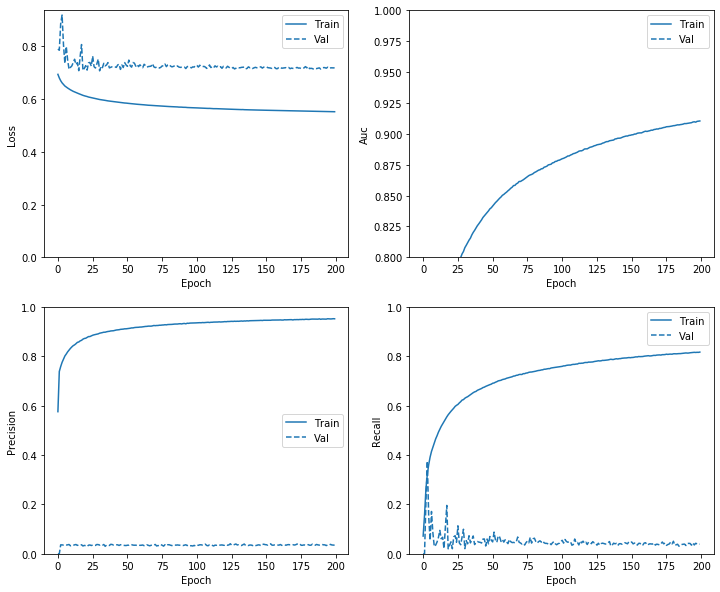

In [14]:
plot_metrics(hist)

In [17]:
test_predict = model.predict(test_input, batch_size=cfg['batch'])

In [18]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.7188594997132953
tp :  182.0
fp :  4832.0
tn :  109854.0
fn :  4175.0
bin_acc :  0.9243383
precision :  0.036298364
recall :  0.041771863
auc :  0.49906325

Legitimate Transactions Detected (True Negatives):  109854
Legitimate Transactions Incorrectly Detected (False Positives):  4832
Fraudulent Transactions Missed (False Negatives):  4175
Fraudulent Transactions Detected (True Positives):  182
Total Fraudulent Transactions:  4357


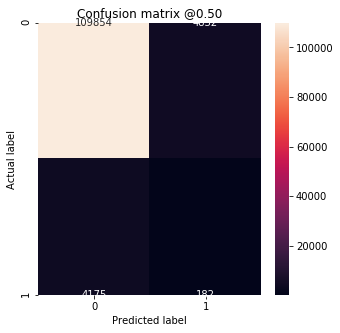

In [23]:
test_results = model.evaluate(test_input, test_label, batch_size=cfg['batch'], verbose=0)
for name, value in zip(model.metrics_names, test_results):
    print(name, ': ', value)
print()

plot_cm(test_label, test_predict)

In [29]:
check_pd = pd.concat([pd.DataFrame(test_predict), pd.DataFrame(test_label)], axis=1)
check_pd.columns = ['predict', 'true']

In [47]:
sort = check_pd.sort_values(by=["true","predict"],ascending=False)
sort[:182]

         predict  true
18726   1.000000     1
25240   1.000000     1
85108   1.000000     1
93211   0.999999     1
88074   0.999996     1
...          ...   ...
81610   0.559647     1
87002   0.557434     1
106678  0.548314     1
115512  0.532040     1
76634   0.519604     1

[182 rows x 2 columns]
